In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Part 1: EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
data = pd.read_csv("../input/titanic/train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

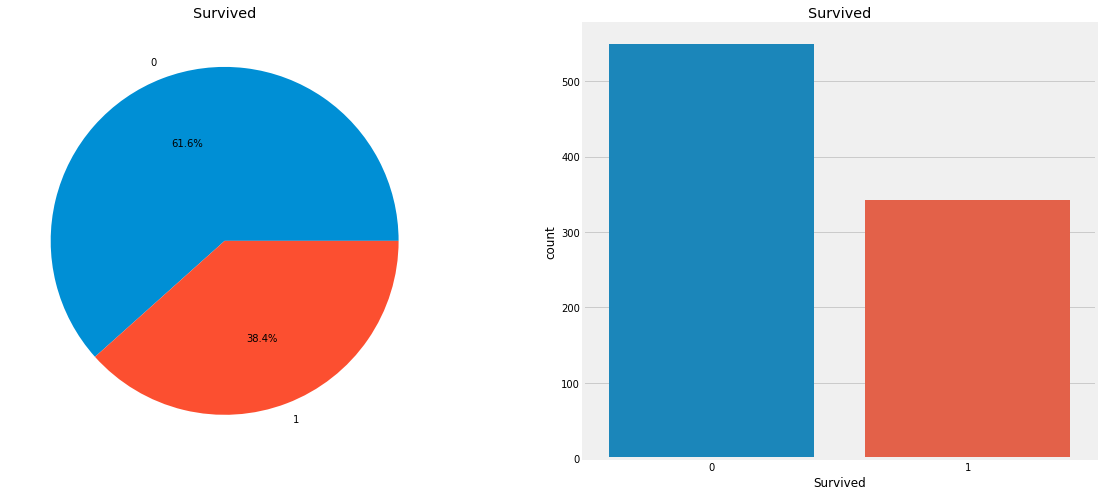

In [5]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data["Survived"].value_counts().plot.pie(autopct="%1.1f%%", ax=ax[0])
ax[0].set_title("Survived")
ax[0].set_ylabel("")

sns.countplot("Survived", data=data, ax=ax[1])
ax[1].set_title("Survived")
plt.show()

전체 탑승객 중, 38.4%만 살아남았음

## 1.1 Analyzing the features

### Sex (categorical)

In [6]:
data.groupby(["Sex", "Survived"])["Survived"].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

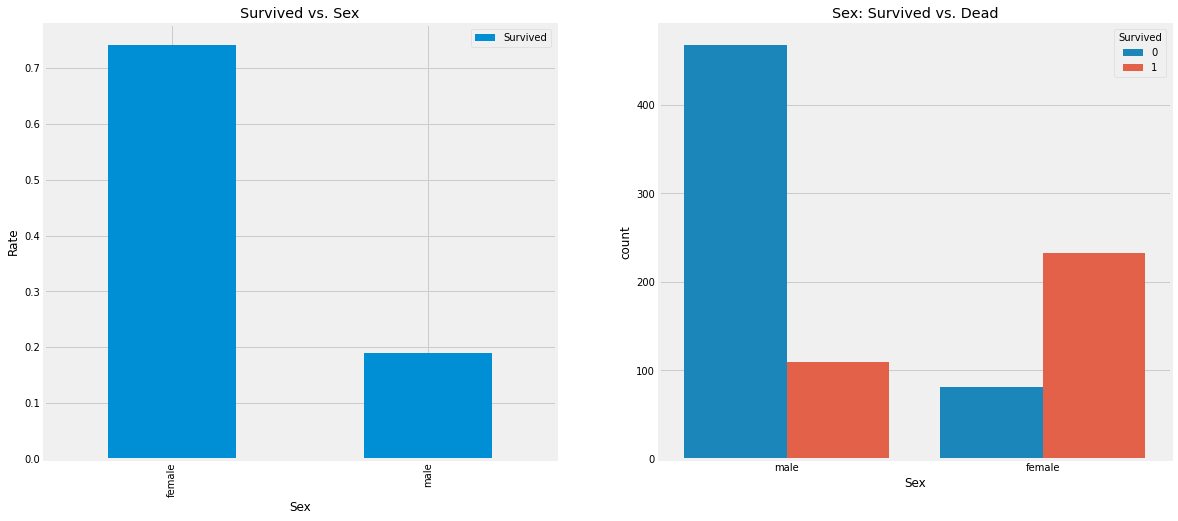

In [7]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[["Sex", "Survived"]].groupby(["Sex"]).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived vs. Sex")
ax[0].set_ylabel("Rate")

sns.countplot("Sex", hue="Survived", data=data, ax=ax[1])
ax[1].set_title("Sex: Survived vs. Dead")
plt.show()

여자의 생존률은 75%, 남자는 18~19% 정도임

### Pclass (ordinal)

In [8]:
pd.crosstab(data.Pclass, data.Survived, margins=True).style.background_gradient()

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


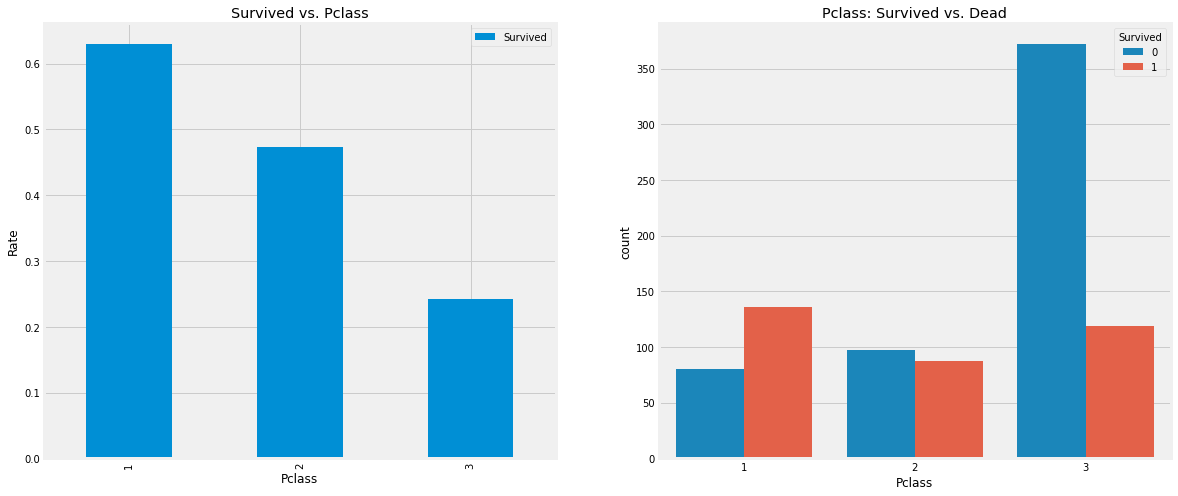

In [9]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

data[["Pclass", "Survived"]].groupby(["Pclass"]).mean().plot.bar(ax=ax[0])
ax[0].set_title("Survived vs. Pclass")
ax[0].set_ylabel("Rate")

sns.countplot("Pclass", hue="Survived", data=data, ax=ax[1])
ax[1].set_title("Pclass: Survived vs. Dead")

plt.show()

1, 2, 3등석 각각의 생존률은 대략 63%, 48%, 24%이다.  
돈많다고 다 사는건 아니지만, 1등석에 탄 사람일수록 구조 우선순위가 높다.

In [10]:
pd.crosstab([data.Sex, data.Survived], data.Pclass, margins=True).style.background_gradient()

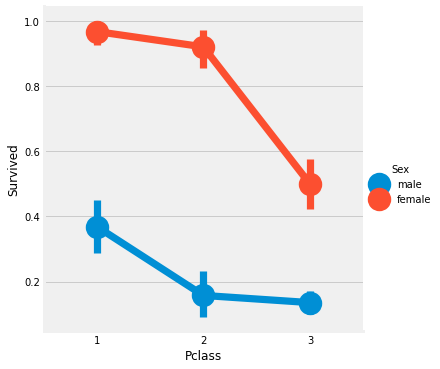

In [11]:
sns.factorplot("Pclass", "Survived", hue="Sex", data=data)
plt.show()

여자이면서 1등석에 탄 사람은 생존률이 거의 95~96%나 된다.  
따라서, Pclass와는 무관하게 여자이면 구조 우선순위가 높다는 것을 알 수 있다.

### Age (continuous)

In [12]:
print("Oldest passenger was of: ", data["Age"].max())
print("Youngest passenger was of: ", data["Age"].min())
print("Average passenger was of: ", data["Age"].mean())

Oldest passenger was of:  80.0
Youngest passenger was of:  0.42
Average passenger was of:  29.69911764705882


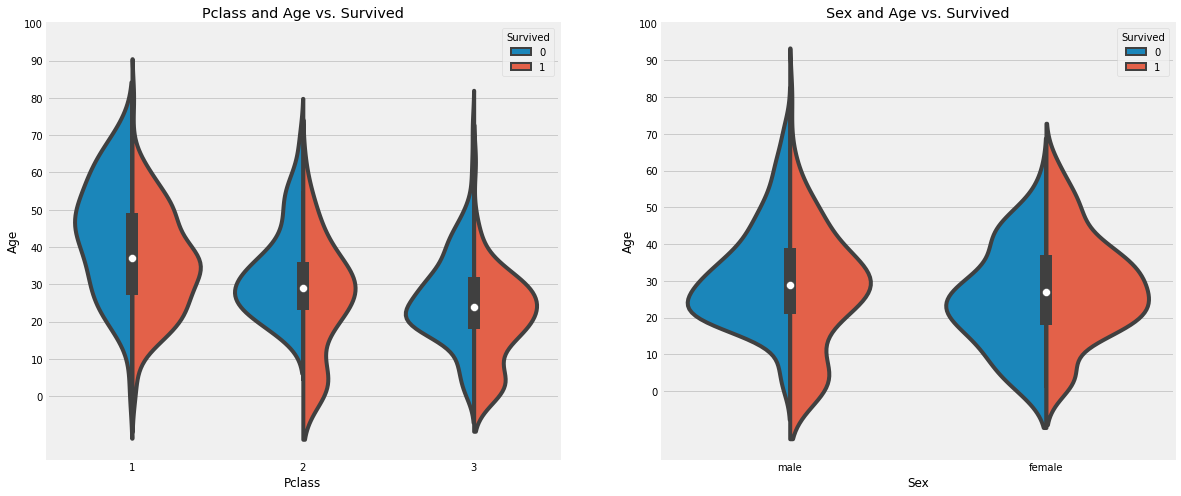

In [13]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

sns.violinplot("Pclass", "Age", hue="Survived", data=data, split=True, ax=ax[0])
ax[0].set_title("Pclass and Age vs. Survived")
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=data, split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs. Survived")
ax[1].set_yticks(range(0, 110, 10))

plt.show()

10세 이하의 아이들은 Pclass가 증가할수록 많아지며, Pclass와 무관하게 생존률이 높다.  
또한, 20~50세의 생존률은 1등석이거나 여자일 경우에 높다.

Age feature에는 null값이 많았는데, 단순히 평균값을 사용하거나 지우는 것은 적절하지 못해보인다.  
따라서, Name feature로 이 값을 채워보자.

In [14]:
data["Initial"] = 0
for i in data:
    data["Initial"] = data.Name.str.extract("([A-Za-z]+)\.")

In [15]:
pd.crosstab(data.Initial, data.Sex).T.style.background_gradient()

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 결과 값들을 Mr/Mrs/Master/Miss/Other의 5가지 category로 바꾸자

In [16]:
data.Initial.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [17]:
data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [18]:
data.groupby("Initial")["Age"].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

이제 위의 5가지 카테고리에 나이를 지정해주자

In [19]:
data.loc[(data.Age.isnull()) & (data.Initial=="Mr"), "Age"] = 33
data.loc[(data.Age.isnull()) & (data.Initial=="Mrs"), "Age"] = 36
data.loc[(data.Age.isnull()) & (data.Initial=="Master"), "Age"] = 5
data.loc[(data.Age.isnull()) & (data.Initial=="Miss"), "Age"] = 22
data.loc[(data.Age.isnull()) & (data.Initial=="Other"), "Age"] = 46

In [20]:
data.Age.isnull().any()

False

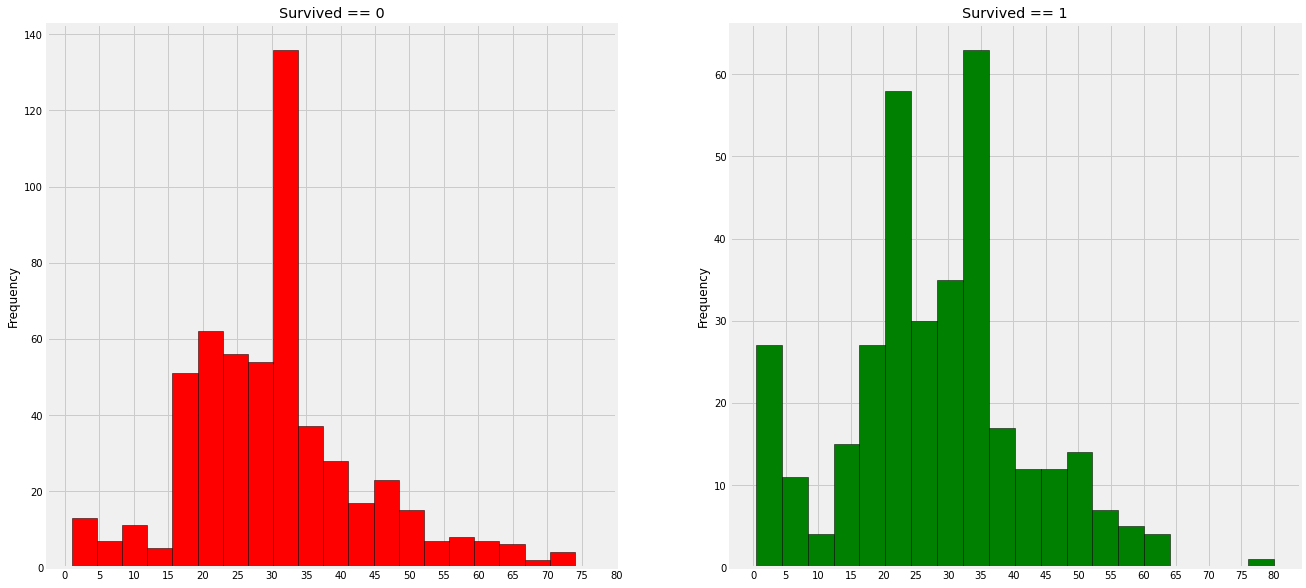

In [21]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

data[data["Survived"] == 0].Age.plot.hist(ax=ax[0], bins=20, edgecolor="black", color="red")
ax[0].set_title("Survived == 0")
x1 = list(range(0, 85, 5))
ax[0].set_xticks(x1)

data[data["Survived"] == 1].Age.plot.hist(ax=ax[1], bins=20, edgecolor="black", color="green")
ax[1].set_title("Survived == 1")
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)

plt.show()

0\~5세의 생존율은 높으며, 30\~40세의 생존율이 가장 낮다.  
추가로, 가장 나이가 많았던 80세 승객은 살아남았다.

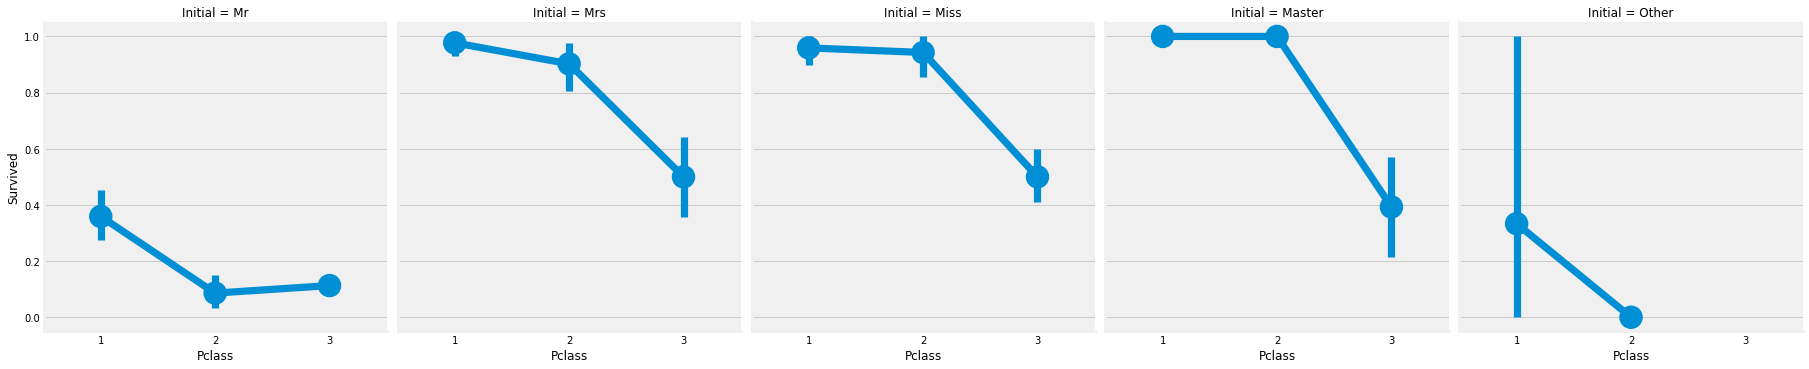

In [22]:
sns.factorplot("Pclass", "Survived", col="Initial", data=data)
plt.show()

위 결과를 통해, 여자거나 어린아이라면 Pclass에 무관하게 생존율이 높다는 것을 알 수 있다.

### Embarked (categorical)

In [23]:
pd.crosstab([data.Embarked, data.Pclass], [data.Sex, data.Survived], margins=True).style.background_gradient()

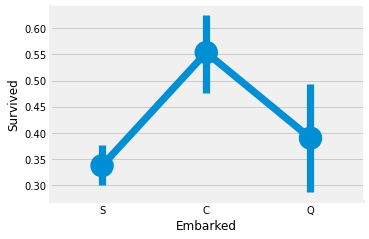

In [24]:
sns.factorplot("Embarked", "Survived", data=data)
plt.gcf().set_size_inches(5, 3)
plt.show()

C항에서 승선한 사람들의 생존률이 가장 높다  
S항에서 승선한 사람들의 생존률이 가장 낮다.

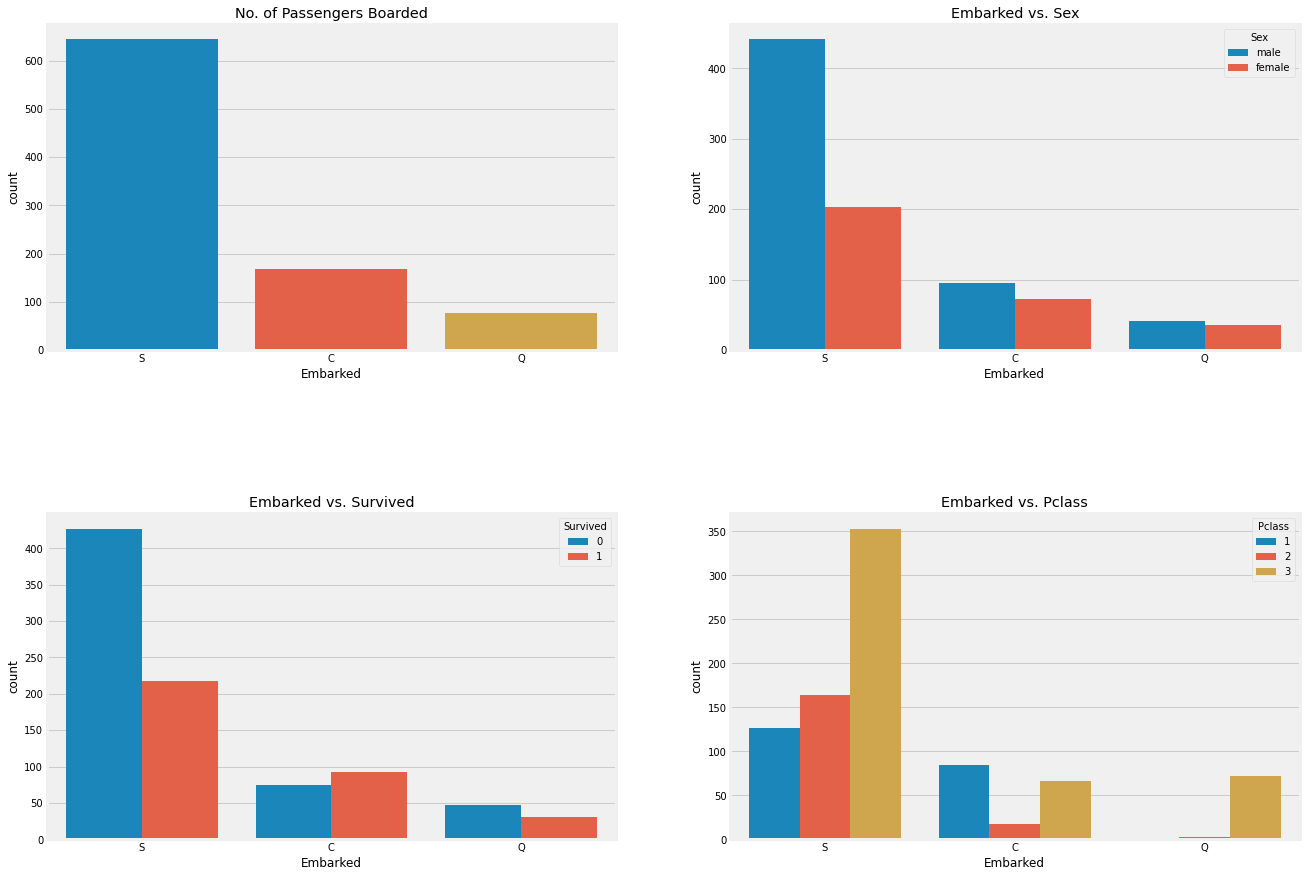

In [25]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
ax[0, 0].set_title("No. of Passengers Boarded")

sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
ax[0, 1].set_title("Embarked vs. Sex")

sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
ax[1, 0].set_title("Embarked vs. Survived")

sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs. Pclass")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

S항에서 가장 많이 탑승했고, 대부분이 Pclass 3이다. (대부분이 Pclass 3이어서 생존률이 낮은 것으로 생각해볼 수 있다.)  
C항에서 탑승한 승객의 경우, 사망자보다 생존자가 더 많다.  
Q항은 95% 이상이 Pclass 3이다.

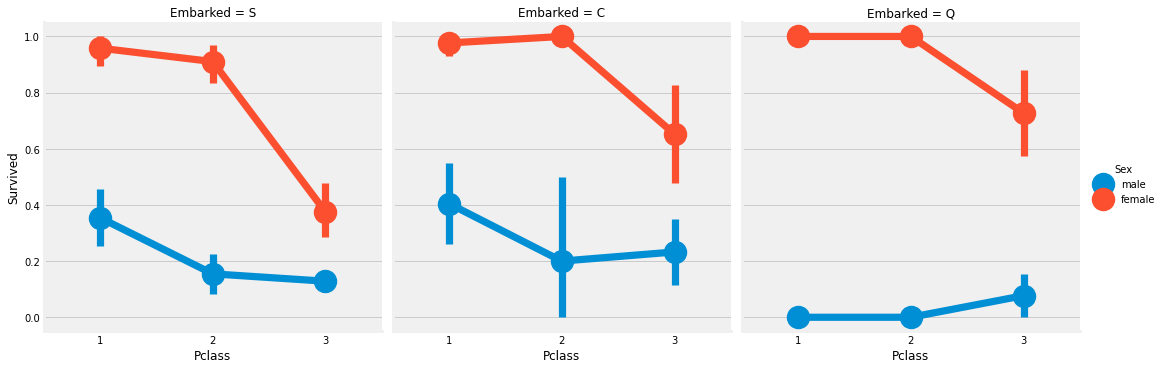

In [26]:
sns.factorplot("Pclass", "Survived", hue="Sex", col="Embarked", data=data)
plt.show()

In [27]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Initial          0
dtype: int64

In [28]:
data["Embarked"].fillna("S", inplace=True)
data.Embarked.isnull().any()

False

### SibSp (discrete)

In [29]:
pd.crosstab(data.SibSp, data.Survived, margins=True).style.background_gradient()

Survived,0,1,All
SibSp,,,
0,398,210,608
1,97,112,209
2,15,13,28
3,12,4,16
4,15,3,18
5,5,0,5
8,7,0,7
All,549,342,891


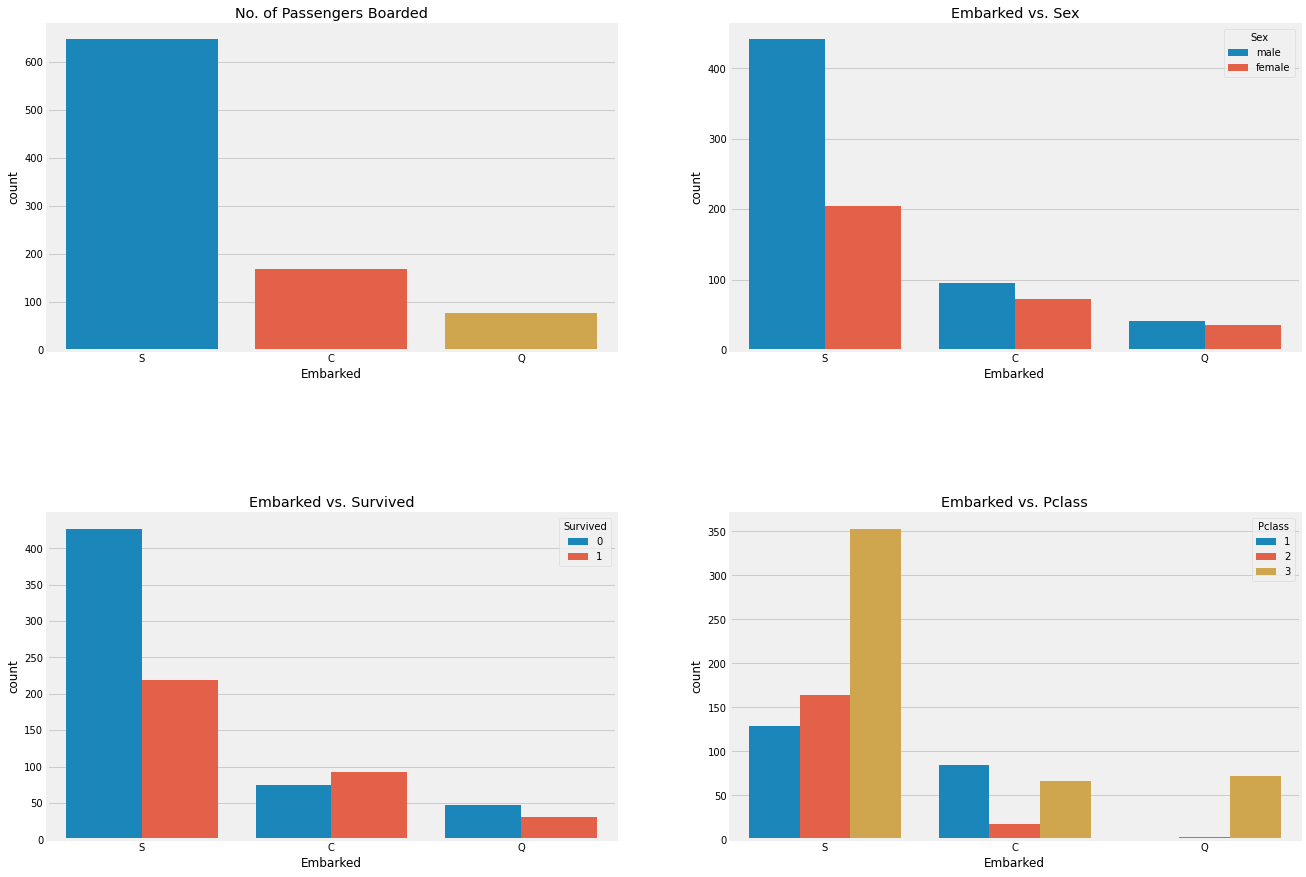

In [30]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))

sns.countplot("Embarked", data=data, ax=ax[0, 0])
ax[0, 0].set_title("No. of Passengers Boarded")

sns.countplot("Embarked", hue="Sex", data=data, ax=ax[0, 1])
ax[0, 1].set_title("Embarked vs. Sex")

sns.countplot("Embarked", hue="Survived", data=data, ax=ax[1, 0])
ax[1, 0].set_title("Embarked vs. Survived")

sns.countplot("Embarked", hue="Pclass", data=data, ax=ax[1, 1])
ax[1, 1].set_title("Embarked vs. Pclass")

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

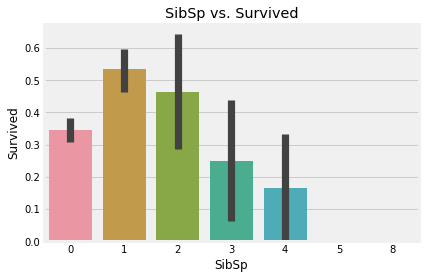

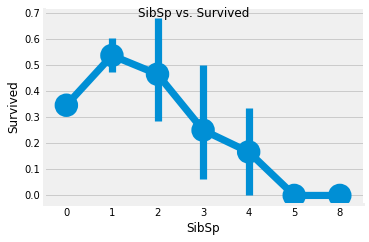

In [31]:
f = sns.barplot("SibSp", "Survived", data=data)
f.set_title("SibSp vs. Survived")

f = sns.factorplot("SibSp", "Survived", data=data)
f.fig.suptitle("SibSp vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

형제 없이 혼자 탑승할 경우의 생존율은 34.5%  
형제수가 증가할수록, 생존율이 감소하는 형태를 보임(배에 가족이 있으면 나보다 가족을 먼저 구하려고 해서?)

In [32]:
pd.crosstab([data.SibSp, data.Survived], data.Pclass).style.background_gradient()

형제 수가 3보다 큰 경우에는 모두 Pclass 3에 해당  
형제 수가 5~8인 경우에는 모두 사망하였는데, 이는 Pclass3인 것도 이유로 볼 수 있음

### Parch

In [33]:
pd.crosstab(data.Parch, data.Pclass).style.background_gradient()

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


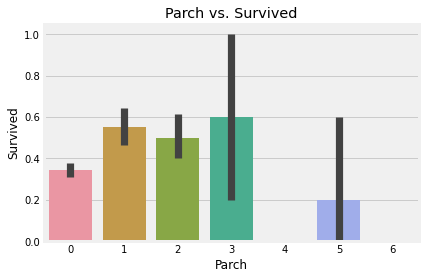

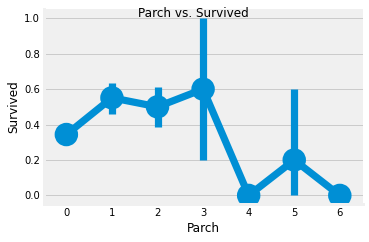

In [34]:
f = sns.barplot("Parch", "Survived", data=data)
f.set_title("Parch vs. Survived")

f = sns.factorplot("Parch", "Survived", data=data)
f.fig.suptitle("Parch vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

형제의 경우와 마찬가지로, 부모 1~3인과 와 함께 탑승한 승객의 경우 생존률이 높다. (부모가 자식을 살리려고 해서?)  
하지만, 부모가 4명이상이 되면 오히려 생존률이 감소하는 모습을 보인다.

### Fare (continuous)

In [35]:
print("Highest fare was: ", data["Fare"].max())
print("Lowest fare was: ", data["Fare"].min())
print("Average fare was: ", data["Fare"].mean())

Highest fare was:  512.3292
Lowest fare was:  0.0
Average fare was:  32.2042079685746


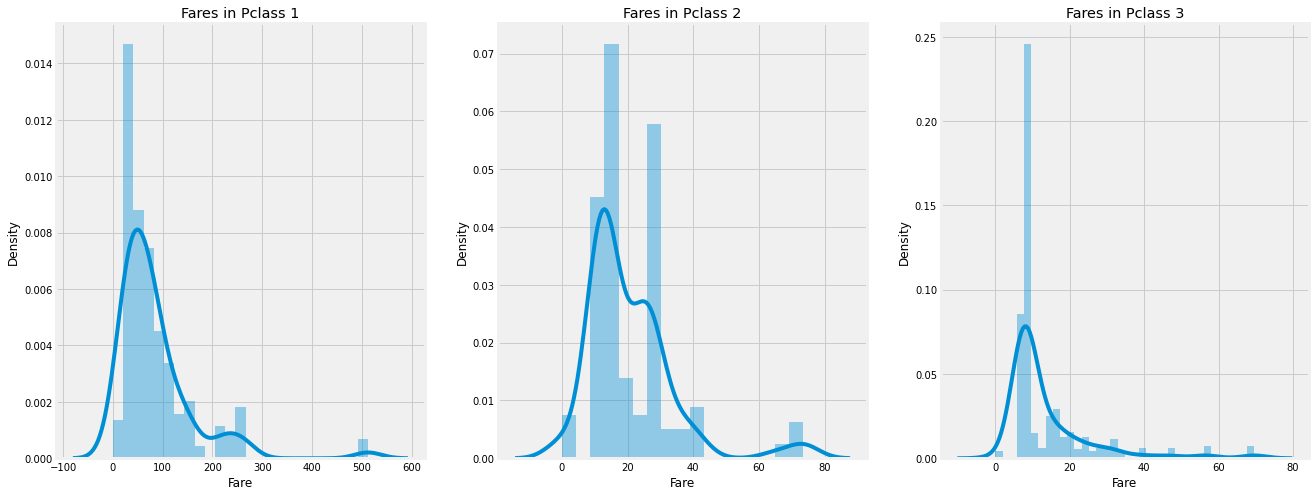

In [36]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))

sns.distplot(data[data["Pclass"] == 1].Fare, ax=ax[0])
ax[0].set_title("Fares in Pclass 1")

sns.distplot(data[data["Pclass"] == 2].Fare, ax=ax[1])
ax[1].set_title("Fares in Pclass 2")

sns.distplot(data[data["Pclass"] == 3].Fare, ax=ax[2])
ax[2].set_title("Fares in Pclass 3")

plt.show()

Pclass1의 탑승권 비용이 매우 높다는 것을 알 수 있다.  
Pclass 내에서의 탑승권 가격 분포는 모두 비슷한 양상을 보인다.  
이 값은 continuous하므로, binning을 통해 discrete value로 바꿀 수 있다.

## 1.2 Observtions in a Nutshell for all features
- Sex
    - 여성의 경우, 남성보다 생존율이 더 높다.
- Pclass
    - 1등석 승객이 생존율이 높고, 3등석 승객의 생존율은 아주 낮다.
    - 1등석에 여성일 경우, 거의 생존율이 1에 달한다.
- Age
    - 5세 미만의 경우, 생존율이 높다.
    - 15~35세의 경우, 많이 사망하였다.
- Embarked
    - C항의 경우, 생존율이 사망율보다 높았다.
    - Q항의 경우, 거의 모든 승객이 3등석 사람으로 구성된다.
- Parch+SibSp
    - 1\~2명의 형제자매 또는 배우자가 탑승하거나 1\~3명의 부모가 있는 경우가 혼자 또는 많은 가족이 있을 경우보다 생존율이 높다.

## 1.3 Correlation Between The Features

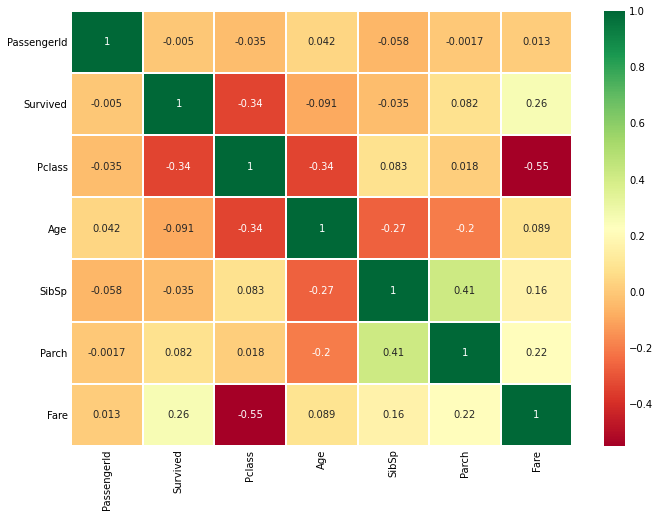

In [37]:
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn", linewidths=0.2)
plt.gcf().set_size_inches(10, 8)
plt.show()


위 correlation matrix에서 아주 높은 값은 보이지 않으므로, 모든 feature를 사용하자.

\[참고\]

- Positive correlation
    - feature A가 증가할 때 feature B도 증가한다면 -> A and B are positively correlated
    - 값이 1일 경우 -> perfect positive correlation
- Negative correlation
    - feature A가 증가할 때 feature B가 감소한다면 -> A and B are negatively correlated
    - 값이 -1일 경우 -> perfect negative correlation
- MultiColinearity
    - 두 feature가 highly or perfectively correlated할 경우, 두 feature는 매우 유사한 정보를 가지고 있으며 분산은 아주 적거나 없게 된다. 이러한 경우를 MultiColinearity라고 한다. (거의 동일한 정보를 가지고 있다는 의미)
    - 즉, feature에 redundant가 있는 경우라고 볼 수 있으며 이러한 redundant를 제거하지 않으면 학습에 방해가 될 수 있기 때문에 제거해주어야 한다.

# 2. Feature Engineering and Data Cleaning

### Age_band

- Age는 continuous feature라서 모델이 학습하기 용이한 형태인 categorical로 변경해주자.
    - continuous feature로 age가 왜 학습하기 어려운지?
        - 예를 들어, 운동선수를 연령별로 구분한다면 (30명이 있고, 모두 나이가 다르다고 가정) 총 30개의 값이 있을 수 있으므로 문제가 됨
- continuous를 categorical로 변경하는 방법으로, 여기서는 binning을 사용

In [38]:
# 총 5개의 구간으로 binning (최고령자 탑승객의 나이가 80세였으므로, 80/5 = 16)
data["Age_band"] = 0
data.loc[data["Age"] <= 16, "Age_band"] = 0
data.loc[(data["Age"] > 16) & (data["Age"] <= 32), "Age_band"] = 1
data.loc[(data["Age"] > 32) & (data["Age"] <= 48), "Age_band"] = 2
data.loc[(data["Age"] > 48) & (data["Age"] <= 64), "Age_band"] = 3
data.loc[data["Age"] > 64, "Age_band"] = 4

data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [39]:
data["Age_band"].value_counts()

1    382
2    325
0    104
3     69
4     11
Name: Age_band, dtype: int64

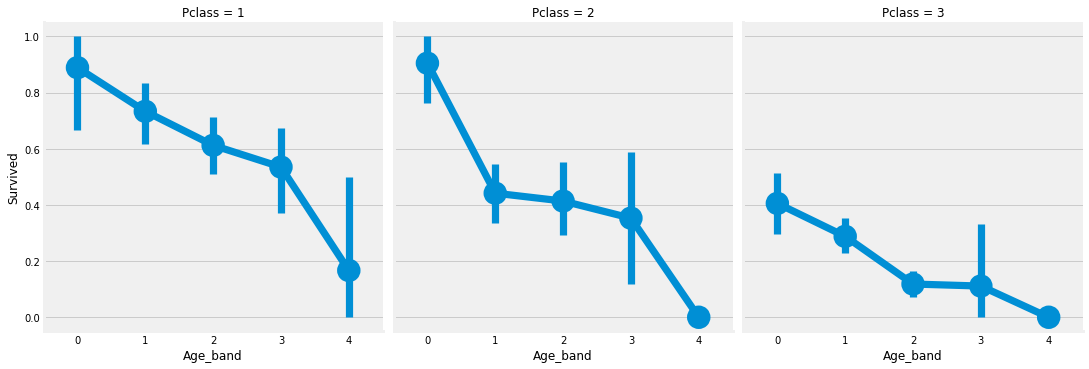

In [40]:
sns.factorplot("Age_band", "Survived", data=data, col="Pclass")
plt.show()

Pclass와 무관하게 나이가 증가할수록 생존률은 낮아짐

### Family_Size and Alone

Family_size = Parch + SibSp

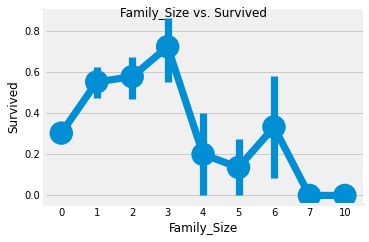

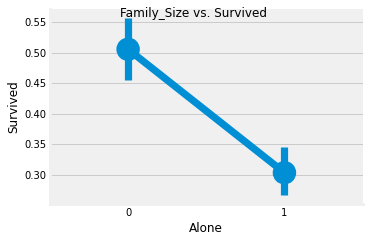

In [41]:
# Family_Size
data["Family_Size"] = 0
data["Family_Size"] = data["Parch"] + data["SibSp"]

# Alone
data["Alone"] = 0
data.loc[data.Family_Size == 0, "Alone"] = 1

f = sns.factorplot("Family_Size", "Survived", data=data)
f.fig.suptitle("Family_Size vs. Survived")
plt.gcf().set_size_inches(5, 3)

f = sns.factorplot("Alone", "Survived", data=data)
f.fig.suptitle("Family_Size vs. Survived")
plt.gcf().set_size_inches(5, 3)

plt.show()

Family_Size = 0일 경우, 생존율이 매우 낮음  
Family_Size가 0에서 3까지는 생존율이 증가하다가 4부터는 감소

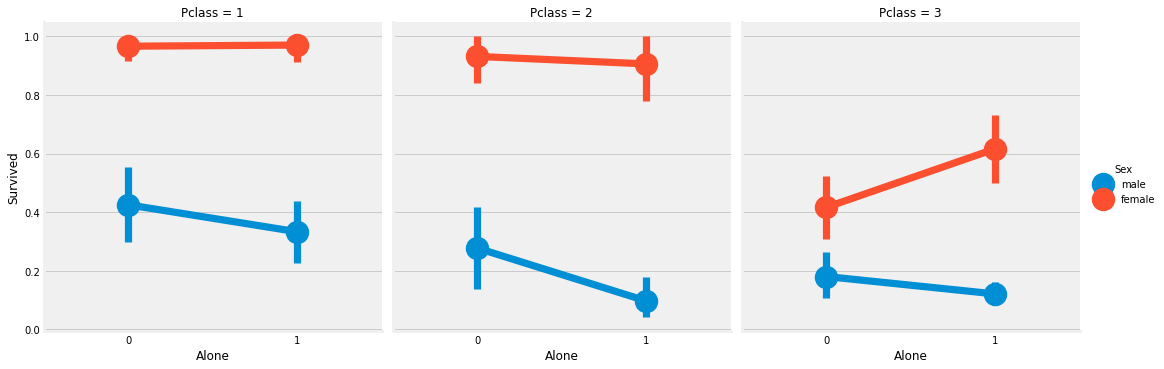

In [42]:
sns.factorplot("Alone", "Survived", data=data, hue="Sex", col="Pclass")
plt.show()

Pclass1과 2에서는 Alone일 경우 사망율이 높음  
Pclass3에서는 Alone일 경우 여성은 오히려 가족이 있는 경우보다 생존율이 높음

### Fare_Range

fare도 continuous feature이기 때문에 ordinal value로 바꾸어주자.

In [43]:
data["Fare_Range"] = pd.qcut(data["Fare"], 4)
data.groupby("Fare_Range")["Survived"].mean().to_frame().style.background_gradient()

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


Fare_Range가 증가하면 생존율도 증가한다.

위의 Fare_Range 구간별로 categorical하게 feature를 만들어주자

In [44]:
data["Fare_cat"] = 0
data.loc[data["Fare"] <= 7.91, "Fare_cat"] = 0
data.loc[(data["Fare"] > 7.91) & (data["Fare"] <= 14.454), "Fare_cat"] = 1
data.loc[(data["Fare"] > 14.454) & (data["Fare"] <= 31.0), "Fare_cat"] = 2
data.loc[(data["Fare"] > 31.0) & (data["Fare"] <= 512.329), "Fare_cat"] = 3

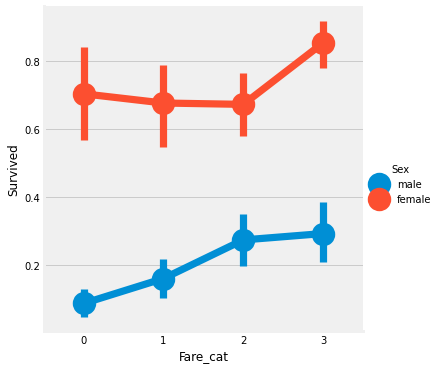

In [45]:
sns.factorplot("Fare_cat", "Survived", data=data, hue="Sex")
plt.show()

Fare_cat이 증가하면 생존율도 증가한다.

### Converting String Values into Numeric

문자열 데이터를 숫자로 변환

In [46]:
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].replace(["S", "C", "Q"], [0, 1, 2], inplace=True)
data["Initial"].replace(["Mr", "Mrs", "Miss", "Master", "Other"],
                        [0, 1, 2, 3, 4], inplace=True)

### Dropping UnNeeded Features
- Name: categorical value로 변환도 불가능하고 필요 없음
- Age: `Age_band` feature가 있으므로 필요 없음
- Ticket: categorical value로 변환도 불가능하고 필요 없음
- Fare: `Fare_cat` feature가 있으므로 필요 없음
- Cabin: NaN 값이 너무 많은데다가 많은 승객들이 여러개의 cabin들을 가지고 있으므로 삭제
- Fare_Range: `Fare_cat` feature가 있으므로 필요 없음
- PassengerId: categorical value로 변환도 불가능하고 필요 없음

In [47]:
data.drop(["Name", "Age", "Ticket", "Fare", "Cabin", "Fare_Range", "PassengerId"],
          axis=1, inplace=True)

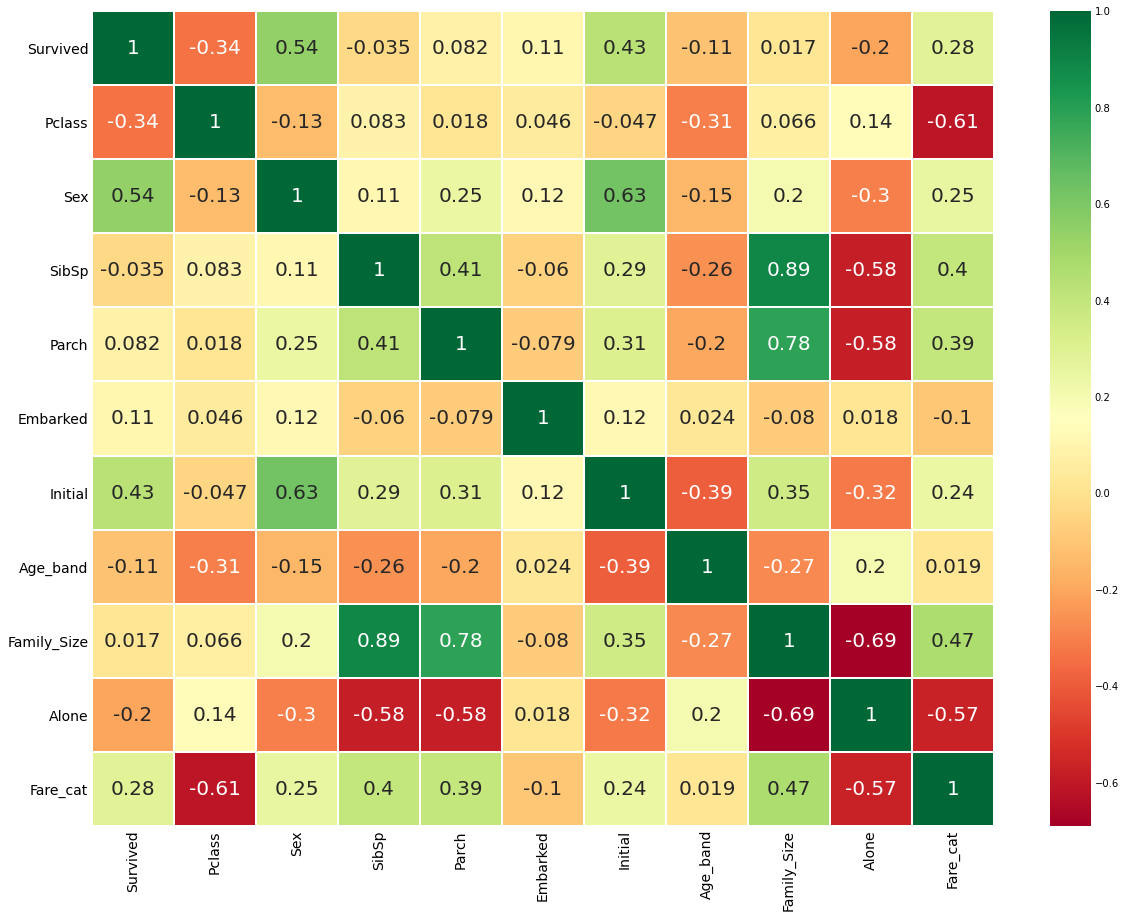

In [48]:
sns.heatmap(data.corr(), annot=True, cmap="RdYlGn",
            linewidths=0.2, annot_kws={"size": 20})

plt.gcf().set_size_inches(18, 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Positively correlated feature들
- SibSp와 Family_Size: 0.89
- Parch와 Family_Size: 0.78

Negatively correlated feature들
- Alone and Family_Size: -0.69

# Part 3: Predictive Modeling

앞서 가공한 feature들을 사용해 아래의 classifier들을 학습시키자!

1. Logistic Regression
2. Support Vector Machines (Linear, radial kernel)
3. Random Forest
4. K-Nearest Neighbours
5. Naive Bayes
6. Decision Tree

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [50]:
train,test=train_test_split(data, test_size=0.3, random_state=0, stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

### Logistic Regression

In [51]:
model = LogisticRegression()
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(pred, test_Y))

The accuracy of the Logistic Regression is 0.8208955223880597


### Support Vector Machine

In [52]:
# linear
model = svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('Accuracy for linear SVM is',metrics.accuracy_score(pred, test_Y))

# radial basis function
model = svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(pred, test_Y))

Accuracy for linear SVM is 0.8171641791044776
Accuracy for rbf SVM is  0.835820895522388


### Random Forest

In [53]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(pred, test_Y))

The accuracy of the Random Forests is 0.8097014925373134


### K-Nearest Neighbours

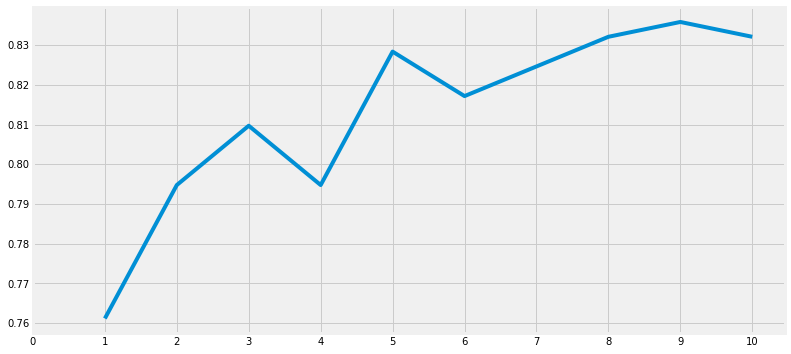

Accuracies for different values of n are: [0.76119403 0.79477612 0.80970149 0.79477612 0.82835821 0.81716418
 0.82462687 0.83208955 0.8358209  0.83208955] with the max value as  0.835820895522388


In [54]:
a_index=list(range(1,11))
a=pd.Series()
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i) 
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a=a.append(pd.Series(metrics.accuracy_score(prediction,test_Y)))
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

In [55]:
model = KNeighborsClassifier(n_neighbors=9) 
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(pred, test_Y))

The accuracy of the KNN is 0.835820895522388


### Naive Bayes

In [56]:
model = GaussianNB()
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(pred, test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### Decision Tree

In [57]:
model = DecisionTreeClassifier()
model.fit(train_X,train_Y)
pred = model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(pred, test_Y))

The accuracy of the Decision Tree is 0.8059701492537313


## Cross Validation

앞에서 분류기가 약 80~83% 정도의 정확도(accuracy)를 보였는데, 과연 이 정확도는 여러 환경에서도 유지될 것이라고 확신할 수 있을까?

정답은 '없다'이다. 그 이유는, test set의 데이터 하나하나에서 모두 90%의 성능을 낸 것이 아니라, 전체 test set에서의 성능을 평균낸 것이기 때문이다.

앞에서 데이터를 `train_test_split()`을 통해 분리하고, 이를 통해 학습을 시키고 성능을 확인하였지만, 이 값은 분리된 각 train, test set에서의 결과이기 때문에 전체 데이터에 대해서도 동일한 성능을 낼 것이라고 보장할 수 없다. (예를 들어, 데이터가 imbalance하여 우리가 test한 데이터에는 특정 class의 데이터만 몰려있을 수도 있음)

즉, training 및 test data가 바뀐다면 accuracy도 변할 것이며, 이를 model variance(모델 분산)이라고 한다. 그렇다면, 이러한 분산을 고려해서 우리의 모델이 데이터셋 전체에 대해서 이정도의 성능을 낸다라고 평가할 수 있는 방법은 없을까? 이를 극복하기 위한 방법 중 하나가 **cross validation**이며, 이를 적용해보자!

5개의 fold(K=5)로 K-Fold Cross Validation을 수행하는 경우, 알고리즘은 다음과 같이 동작한다.

1. 전체 데이터셋을 K=5개의 subset으로 분리한다.
2. 5개의 subset 중, 4개로 모델을 학습하고 1개로 test하여 성능을 뽑아낸다.
3. 위의 2 과정을 모든 다른 subset에 대해서 수행하고, 각각의 측정된 성능들을 평균낸 성능을 구한다.
4. 3에서 구한 성능은 전체 데이터셋에 대해서 더 일반화된 성능이라고 볼 수 있으며, 이 결과가 cross validation으로 측정한 성능이다.

In [58]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

xyz=[]
accuracy=[]
std=[]

kfold = KFold(n_splits=10, random_state=22)
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree','Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),RandomForestClassifier(n_estimators=100)]

for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.791223,0.045646
Radial Svm,0.828290,0.034427
Logistic Regression,0.803596,0.024186
KNN,0.812659,0.041477
Decision Tree,0.812609,0.027677
Naive Bayes,0.799139,0.028757
Random Forest,0.811473,0.029021


<AxesSubplot:>

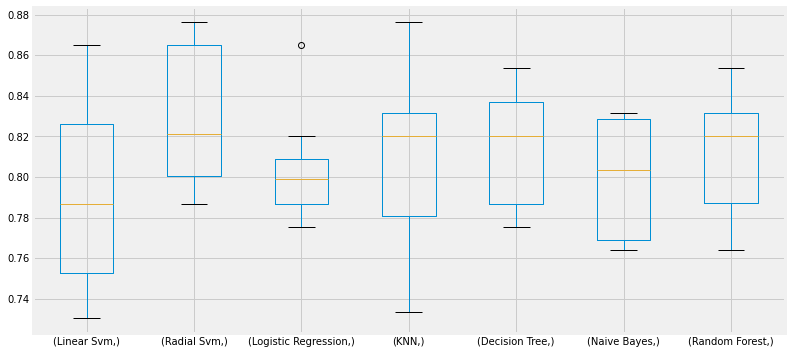

In [59]:
plt.subplots(figsize=(12,6))
box=pd.DataFrame(accuracy, index=[classifiers])
box.T.boxplot()

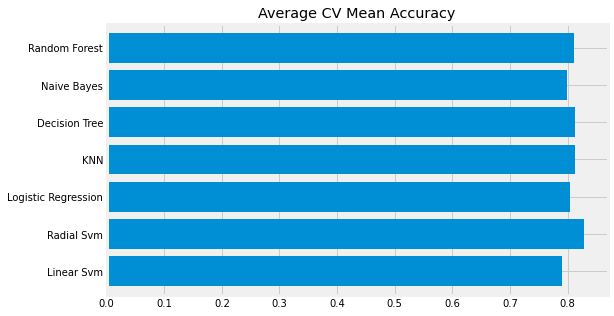

In [60]:
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)
plt.title('Average CV Mean Accuracy')
fig=plt.gcf()
fig.set_size_inches(8,5)
plt.show()

## Confusion Matrix

Confusion Matrix란 분류 알고리즘의 성능을 행렬로 나타낸 것을 의미한다.  
각 행은 분류기가 예측한 결과, 각 열은 정답을 나타낸다.

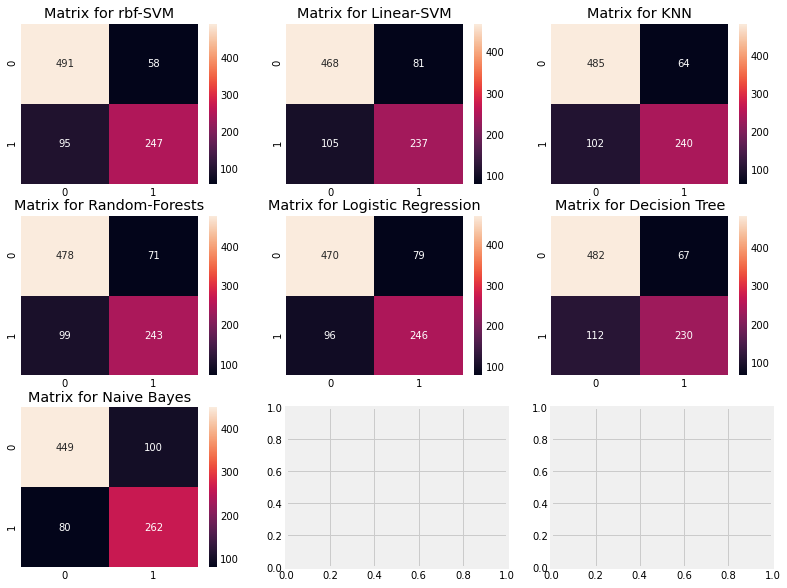

In [61]:
f,ax=plt.subplots(3,3,figsize=(12,10))
y_pred = cross_val_predict(svm.SVC(kernel='rbf'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for rbf-SVM')
y_pred = cross_val_predict(svm.SVC(kernel='linear'),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Linear-SVM')
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[0,2],annot=True,fmt='2.0f')
ax[0,2].set_title('Matrix for KNN')
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[1,2],annot=True,fmt='2.0f')
ax[1,2].set_title('Matrix for Decision Tree')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ax[2,0],annot=True,fmt='2.0f')
ax[2,0].set_title('Matrix for Naive Bayes')
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### Interpreting Confusion Matrix

**행은 분류기가 예측한 결과**, **열은 정답**을 의미한다는 것을 염두해두고 결과를 분석해보자.

좌측 상단 결과인 rbf-SVM을 예로 들면, 다음과 같다.
1. **Accuracy**
    - **491(for dead) + 247(for survived)**를 맞추어서, 정확도(accuracy)는 **(491+247)/891 = 82.8%**이다. (대각성분)
2. **Errors**
    - **58명을 dead(0)라고 잘못 예측**하였고, **95명을 survived라고 잘못 예측**하였다.

rbf-SVM을 맨마지막 Naive Bayes와 비교하면 다음과 같다.
- rbf-SVM은 dead를 더 잘 맞추고, Naive Bayes는 survived를 더 잘 맞춘다.

### Hyper-Parameters Tuning

머신러닝 모델의 hyperparameter 조정해서 모델이 더 좋은 성능을 낼 수 있는 hyperparameter 조합을 찾는 과정을 hyperparameter tuning이라고 한다.

SVM과 RandomForest 모델에 대해서 grid search를 이용해 hyperparameter tuning을 수행해보자.

In [62]:
from sklearn.model_selection import GridSearchCV

C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel':kernel,'C':C,'gamma':gamma}

# SVM Classifier
gd=GridSearchCV(estimator=svm.SVC(),param_grid=hyper,verbose=True)
gd.fit(X,Y)

print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8282593685267716
SVC(C=0.6, gamma=0.1)


[Parallel(n_jobs=1)]: Done 1200 out of 1200 | elapsed:   23.7s finished


In [63]:
n_estimators=range(100,1000,100)
hyper={'n_estimators':n_estimators}

# Random Forest
gd=GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)

print(gd.best_score_)
print(gd.best_estimator_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   37.9s finished


0.8193208210407382
RandomForestClassifier(n_estimators=900, random_state=0)


두 모델에서 가장 좋은 결과를 보이는 hyperparameter 조합 및 그 결과는 다음과 같다.

Rbf-Svm : 82.82% with C=0.5 and gamma=0.1.  
RandomForest: 81.8% with n_estimators=900.


## Ensembling

다양한 모델을 조합하여 하나의 강력한 모델을 만드는 앙상블 기법 중, 다음의 3가지를 적용해보자.

1. Voting Classifier
2. Bagging
3. Boosting

### Voting Classifier

In [64]:
from sklearn.ensemble import VotingClassifier
ensemble_lin_rbf=VotingClassifier(estimators=[('KNN',KNeighborsClassifier(n_neighbors=10)),
                                              ('RBF',svm.SVC(probability=True,kernel='rbf',C=0.5,gamma=0.1)),
                                              ('RFor',RandomForestClassifier(n_estimators=500,random_state=0)),
                                              ('LR',LogisticRegression(C=0.05)),
                                              ('DT',DecisionTreeClassifier(random_state=0)),
                                              ('NB',GaussianNB()),
                                              ('svm',svm.SVC(kernel='linear',probability=True))
                                             ], voting='soft').fit(train_X,train_Y)

print('The accuracy for ensembled model is:',ensemble_lin_rbf.score(test_X,test_Y))
cross=cross_val_score(ensemble_lin_rbf,X,Y, cv = 10,scoring = "accuracy")
print('The cross validated score is',cross.mean())

The accuracy for ensembled model is: 0.8246268656716418
The cross validated score is 0.8260424469413234


### Bagging

In [65]:
from sklearn.ensemble import BaggingClassifier

# Bagged KNN
model=BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=3),random_state=0,n_estimators=700)
model.fit(train_X,train_Y)

prediction=model.predict(test_X)
print('The accuracy for bagged KNN is:',metrics.accuracy_score(prediction,test_Y))

result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged KNN is:',result.mean())

The accuracy for bagged KNN is: 0.835820895522388
The cross validated score for bagged KNN is: 0.8171660424469414


In [66]:
# Bagged DecisionTree
model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),random_state=0,n_estimators=100)
model.fit(train_X,train_Y)

prediction=model.predict(test_X)
print('The accuracy for bagged Decision Tree is:',metrics.accuracy_score(prediction,test_Y))

result=cross_val_score(model,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for bagged Decision Tree is:',result.mean())

The accuracy for bagged Decision Tree is: 0.832089552238806
The cross validated score for bagged Decision Tree is: 0.8160174781523096


### Boosting

In [67]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost(Adaptive Boosting)
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.1)
result=cross_val_score(ada,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8271660424469414


In [68]:
from sklearn.ensemble import GradientBoostingClassifier

# Stochastic Gradient Boosting
grad=GradientBoostingClassifier(n_estimators=500,random_state=0,learning_rate=0.1)
result=cross_val_score(grad,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for Gradient Boosting is:',result.mean())

The cross validated score for Gradient Boosting is: 0.8137827715355804


In [69]:
import xgboost as xg

# XGBoost
xgboost=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X,Y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

[01:53:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:53:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

가장 높은 정확도를 보인 AdaBoost에서 하이퍼파라미터튜닝을 해보자.

In [70]:
# Hyper-Parameter Tuning for AdaBoost

n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper={'n_estimators':n_estimators,'learning_rate':learn_rate}
gd=GridSearchCV(estimator=AdaBoostClassifier(),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  9.7min finished


0.8271483271608814
AdaBoostClassifier(learning_rate=0.05, n_estimators=300)


n_estimators=200, learning_rate=0.05에서 83.16%의 가장 좋은 성능을 보였다.

### Confusion Matrix for the Best Model

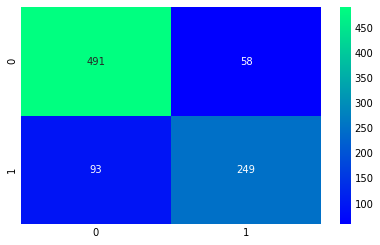

In [71]:
ada=AdaBoostClassifier(n_estimators=200,random_state=0,learning_rate=0.05)
result=cross_val_predict(ada,X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,result),cmap='winter',annot=True,fmt='2.0f')
plt.show()

### Feature Importance

[02:03:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


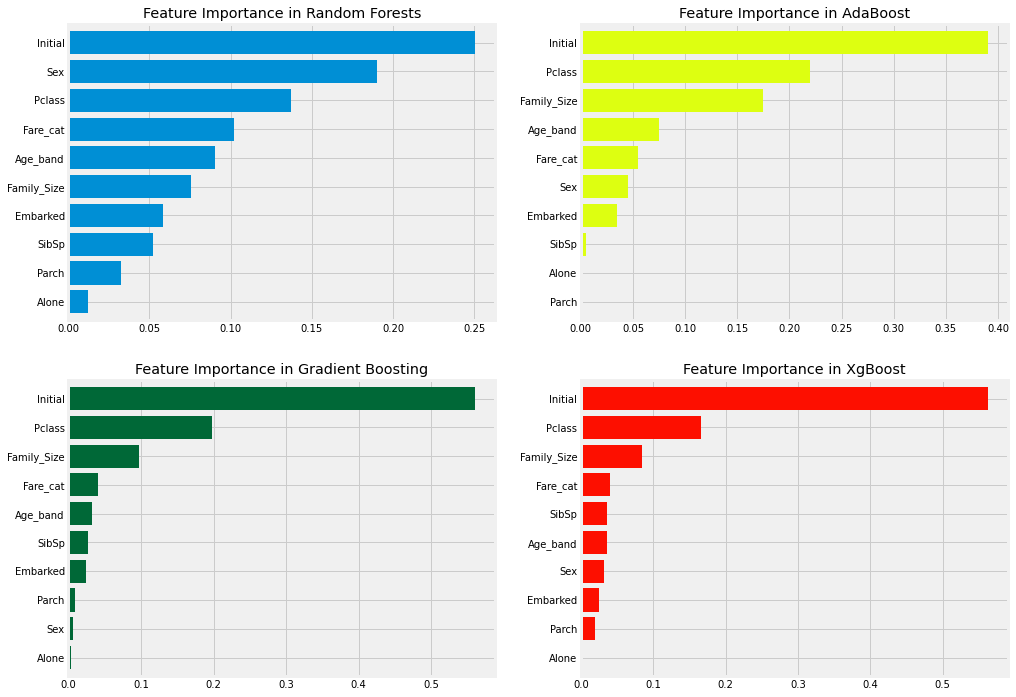

In [72]:
f,ax=plt.subplots(2,2,figsize=(15,12))

model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')

model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')

plt.show()

Observations:
1. `Initial`, `Fare_cat`, `Pclass`, `Family_Size`가 중요한 feature이다.
2. 성별은 RandomForests에서만 중요한 feature이다.
    - EDA에서는 성별이 중요한 feature였던 것과 상반된 결과인데 잘못된것일까?
    - `Initial` feature가 모든 모델에서 중요한 feature로 나타나는데, `Initial` feature와 `Sex`가 positive correlation을 보였으므로 이에 반영된 것이라고 볼 수 있음

3. 2와 유사하게 `Pclass` 및 `Fare_cat`은 탑승객 정보를 나타내고, `Alone`, `Parch`, `SibSp`는 `Family_Size`를 나타낸다.